In [81]:
%pylab inline
import pandas as pd
import xgboost as xgb
from xgboost.sklearn import XGBRegressor
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
rcParams['figure.figsize'] = 8, 5

Populating the interactive namespace from numpy and matplotlib


/home/sasha/Projects/shad-ml-notebooks/env3/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['clf', 'legend']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


# Dataset

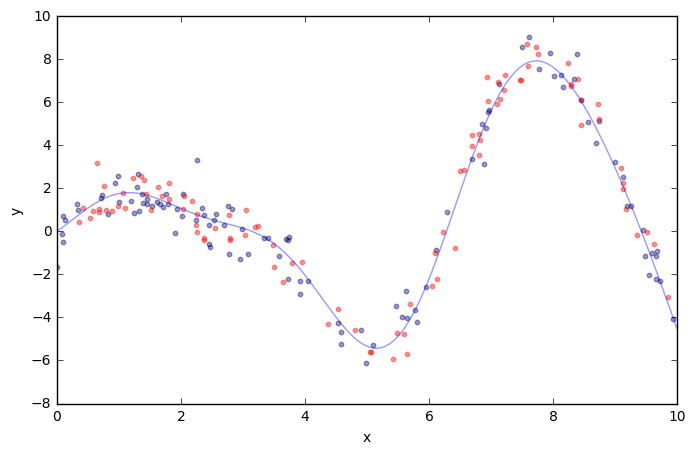

In [34]:
def ground_truth(x):
    return x * np.sin(x) + np.sin(2 * x)

def gen_data(n_samples=200):
    np.random.seed(13)
    x = np.random.uniform(0, 10, size=n_samples)
    x.sort()
    y = ground_truth(x) + 0.75 * np.random.normal(size=n_samples)
    train_mask = np.random.randint(0, 2, size=n_samples).astype(np.bool)
    x_train, y_train = x[train_mask, np.newaxis], y[train_mask]
    x_test, y_test = x[~train_mask, np.newaxis], y[~train_mask]
    return x_train, x_test, y_train, y_test

X_train, X_test, y_train, y_test = gen_data(200)

x_plot = np.linspace(0, 10, 500)

def plot_data(figsize=(8, 5)):
    fig = plt.figure(figsize=figsize)
    gt = plt.plot(x_plot, ground_truth(x_plot), alpha=0.4, label='ground truth')

    plt.scatter(X_train, y_train, s=10, alpha=0.4)
    plt.scatter(X_test, y_test, s=10, alpha=0.4, color='red')
    plt.xlim((0, 10))
    plt.ylabel('y')
    plt.xlabel('x')

plot_data(figsize=(8, 5));

# RF

In [29]:
n_estimators = 1000
rf = RandomForestRegressor(n_estimators=n_estimators, random_state=30)
loss = metrics.mean_squared_error
rf.fit(X_train, y_train)
rf_errors = []
rf_estimators = rf.estimators_
for n in range(1, n_estimators):
    rf.estimators_ = rf_estimators[:n]
    rf_errors.append(loss(y_test, rf.predict(X_test)))

In [66]:
def plot_errors(*args, fig=None, **kwargs):
    ax = gca()
    ax.plot(*args, **kwargs)
    ax.set_ylim((0, 1.5))
    ylabel('MSE')
    xlabel('n_estimators')

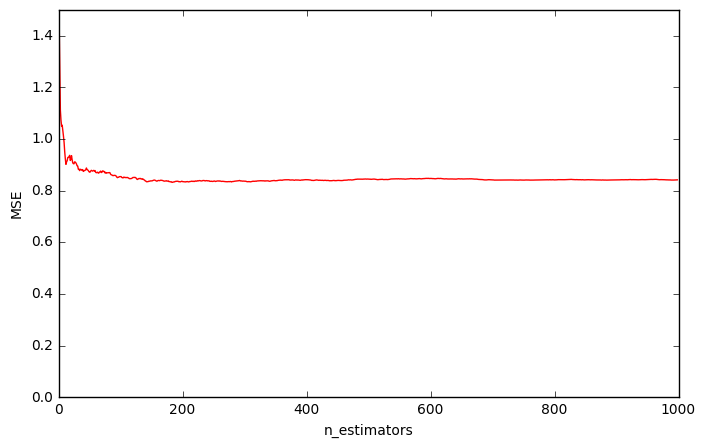

In [67]:
plot_errors(rf_errors, c='r')

# GBT 

$$\tilde{x}^m = \tilde{x}^{m-1} - \lambda_m \nabla f(\tilde{x}^{m-1})$$

$$\tilde{y}^m = \tilde{y}^{m-1} - \lambda_m \nabla Q(\tilde{y}^{m-1}, y)$$

![SGD](http://sebastianruder.com/content/images/2016/09/saddle_point_evaluation_optimizers.gif)

$$b_i = learn(X, -\nabla Q(\tilde{y}^{m-1}, y))$$

## Example
$$ Q(\tilde{y}^m, y) = \frac12 \sum_{i=1}^L (\tilde{y}_i^m - y_i)^2 $$
$$ -\nabla Q(\tilde{y}^m, y) 
= -\nabla \left( \frac12 \sum_{i=1}^L (\tilde{y}_i^m - y_i)^2 \right)
= \sum_{i=1}^L (y_i - \tilde{y}_i^m)
$$

## AnyBoost
$$ Q(\tilde{y}^m, y) = \frac1L \sum_{i=1}^L \mathcal{L}(\tilde{y}^m y) $$
$$ -\nabla Q(\tilde{y}^m, y) 
= -\frac1L \left [\frac{\partial \mathcal{L}(\tilde{y}_i^m y_i)}{\partial \tilde{y}_i^m} \right]_{i=1}^L 
= -\frac1L \left[ \frac{\partial \mathcal{L}(M_i^m)}{\partial M_i^m} y_i \right]_{i=1}^L$$


## AdaBoost
$$w_i^m 
= - \frac{\partial \mathcal{L}(M_i^m)}{\partial M_i^m} y_i
= - \frac{\partial \exp(-M_i^m)}{\partial M_i^m} y_i
= \exp(-M_i^m)
= \exp \left( -y_i \sum_{t=1}^{m} \lambda_t b_t(x_i) \right)
= \prod_{t=1}^m \exp(-y_i \lambda_t b_t(x_i))
= w_i^{m-1} \exp(-y_i \lambda_m b_m(x_i))
$$

In [73]:
def get_ensemble_errors(clf):
    clf.fit(X_train, y_train)
    train_loss , test_loss= [], []
    estimators = clf.estimators_
    for n in range(1, n_estimators):
        clf.estimators_ = estimators[:n]
        train_loss.append(loss(y_train, clf.predict(X_train)))
        test_loss.append(loss(y_test, clf.predict(X_test)))
    return train_loss , test_loss
    
sklearn_gbt = GradientBoostingRegressor(
    n_estimators=n_estimators,
    max_depth=1,
    learning_rate=1.0,
    random_state=50)

gbt_train_loss , gbt_test_loss = get_ensemble_errors(sklearn_gbt)

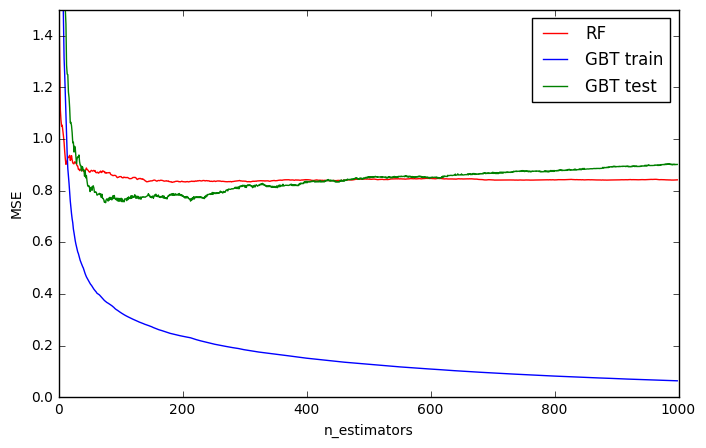

In [75]:
plot_errors(rf_errors, c='r', label='RF')
plot_errors(gbt_train_loss, c='b', label='GBT train')
plot_errors(gbt_test_loss, c='g', label='GBT test')
legend();

In [ ]:
for clf_args in [
        {'subsample': 1, 'learning_rate': 1},
        {'subsample': 1, 'learning_rate': 0.1},
        {'subsample': 1, 'learning_rate': 0.01},
        {'subsample': 0.5, 'learning_rate': 1},
        {'subsample': 0.5, 'learning_rate': 0.1},
        {'subsample': 0.5, 'learning_rate': 0.01},
    ]:
    clf = GradientBoostingRegressor(
        n_estimators=n_estimators,
        random_state=50,
        **clf_args)
    suffix = "subsample: {subsample}; rate: {learning_rate}".format(**clf_args)
    train_loss , test_loss = get_ensemble_errors(clf)
    # plot_errors(train_loss, label='Train ' + suffix)
    plot_errors(test_loss, label='Test ' + suffix + "; Best: {:.3}".format(min(test_loss)))
plot_errors(rf_errors, label='RF test')

ax = gca()
ax.set_ylim((0, 2.5))
legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);

# Links

- https://xgboost.readthedocs.io/en/latest/model.html
- https://github.com/dmlc/xgboost/tree/master/demo
- https://www.datarobot.com/blog/gradient-boosted-regression-trees/
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://zhanpengfang.github.io/418home.html